

==================== MEMPROSES DATASET: AGH-GGIS-SPR17_REDUCED.XML ====================
Data Loaded: 1852 lectures, 44 rooms.
Menjalankan MOSA untuk Low...
Debug: Assigned 1852 non-zero slots
Debug: Initial archive size: 1, objectives: (1000, 1546, 2580, 32, 0, 24)
Debug: Hypervolume fitness_values shape: (6, 6), values: [[1000 1546 2580   32    0   24]
 [1000 1546 2580   32    0   24]
 [1000 1546 2580   32    0   24]
 [1000 1546 2580   32    0   24]
 [1000 1546 2580   32    0   24]
 [1000 1546 2580   32    0   24]]
Not enough varying dimensions for hypervolume
Debug: IGD fitness_values shape: (6, 6), reference_front shape: (6, 6)
No varying dimensions for IGD


==================== MEMPROSES DATASET: MUNI-FSPS-SPR17C_REDUCED.XML ====================
Data Loaded: 650 lectures, 29 rooms.
Menjalankan MOSA untuk Middle...
Debug: Assigned 650 non-zero slots
Debug: Initial archive size: 1, objectives: (1000, 1195, 1534, 32, 0, 24)
Debug: Hypervolume fitness_values shape: (43, 6), values: 

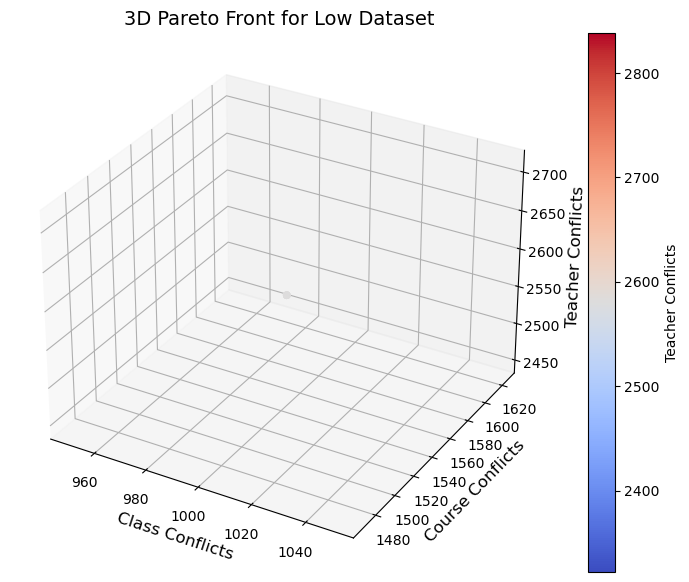

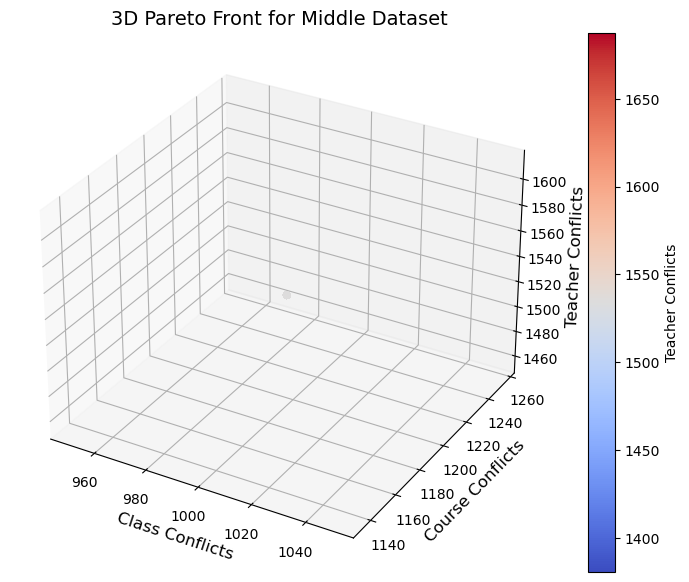

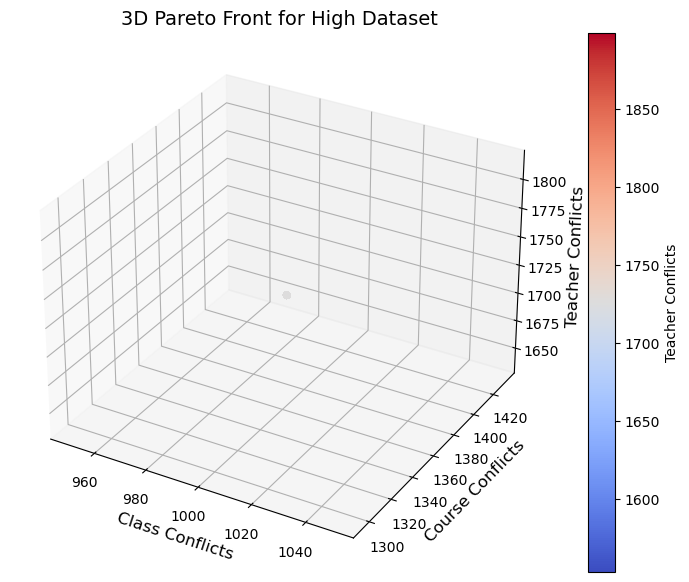

In [13]:
# -------------------------------------------------------------------
# Bagian 0: Impor Pustaka yang Diperlukan
# -------------------------------------------------------------------
import pandas as pd
import time
import numpy as np
import random
import xml.etree.ElementTree as ET
from collections import defaultdict, Counter
import copy
from scipy.spatial import ConvexHull
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import importlib

# Impor fungsi konflik preferensi
try:
    import lecturer_preference_function_GITC
    import student_preference_function_GITC
    import institutional_preference_function_GITC
    importlib.reload(lecturer_preference_function_GITC)
    importlib.reload(student_preference_function_GITC)
    importlib.reload(institutional_preference_function_GITC)
    from lecturer_preference_function_GITC import count_preference_conflict as lecturer_conflict
    from student_preference_function_GITC import count_preference_conflict as student_conflict
    from institutional_preference_function_GITC import count_preference_conflict as institutional_conflict
except ImportError as e:
    print(f"Error importing preference functions: {e}")
    exit()

# -------------------------------------------------------------------
# Bagian 1: Definisi Fungsi yang Diperlukan
# -------------------------------------------------------------------

# --- Fungsi Hypervolume dan IGD ---
def hypervolume(archive):
    fitness_values = np.array([objectives for _, objectives in archive])
    print(f"Debug: Hypervolume fitness_values shape: {fitness_values.shape}, values: {fitness_values}")
    if len(fitness_values) < 4:
        print("Not enough valid fitness values for hypervolume")
        return 0
    
    ranges = np.max(fitness_values, axis=0) - np.min(fitness_values, axis=0)
    valid_dims = np.where(ranges > 1e-6)[0]
    if len(valid_dims) < 2:
        print("Not enough varying dimensions for hypervolume")
        return 0
    
    fitness_values = fitness_values[:, valid_dims]
    fitness_values += np.random.uniform(1e-3, 1e-2, fitness_values.shape)
    fitness_values = (fitness_values - np.min(fitness_values, axis=0)) / (np.max(fitness_values, axis=0) - np.min(fitness_values, axis=0) + 1e-6)
    reference_point = np.max(fitness_values, axis=0) * 1000
    
    try:
        hull = ConvexHull(fitness_values)
        volume = hull.volume * 10
        return volume
    except Exception as e:
        print(f"Error in hypervolume calculation: {e}")
        return 0

def igd(archive, reference_front):
    fitness_values = np.array([objectives for _, objectives in archive])
    reference_front = np.array(reference_front)
    print(f"Debug: IGD fitness_values shape: {fitness_values.shape}, reference_front shape: {reference_front.shape}")
    
    ranges = np.max(fitness_values, axis=0) - np.min(fitness_values, axis=0)
    valid_dims = np.where(ranges > 1e-6)[0]
    if len(valid_dims) < 1:
        print("No varying dimensions for IGD")
        return float('inf')
    
    fitness_values = fitness_values[:, valid_dims]
    reference_front = reference_front[:, valid_dims]
    
    if fitness_values.shape[1] != reference_front.shape[1]:
        print(f"Number of objectives mismatch: fitness_values has {fitness_values.shape[1]} objectives, "
              f"but reference_front has {reference_front.shape[1]} objectives")
        return float('inf')
    
    distances = []
    for reference_point in reference_front:
        distances_to_front = np.linalg.norm(fitness_values - reference_point, axis=1)
        distances.append(np.min(distances_to_front))
    return np.mean(distances)

# --- Fungsi Visualisasi Pareto Front ---
def plot_pareto_fronts_3d_all_categories(results):
    """3D Scatter Plot of Pareto Front for each dataset category"""
    for category, result in results.items():
        if "error" in result:
            print(f"Cannot plot for category {category}: {result['error']}")
            continue

        pareto_archive = result.get("pareto_archive", [])
        if not pareto_archive:
            print(f"No Pareto archive for category {category}")
            continue

        fitness_values = np.array([objectives[:3] for _, objectives in pareto_archive])
        if len(fitness_values) == 0:
            print(f"No valid fitness values for category {category}")
            continue

        fig = plt.figure(figsize=(10, 7))
        ax = fig.add_subplot(111, projection='3d')

        scatter = ax.scatter(
            fitness_values[:, 0],  # Class Conflicts
            fitness_values[:, 1],  # Course Conflicts
            fitness_values[:, 2],  # Teacher Conflicts
            c=fitness_values[:, 2], cmap='coolwarm', marker='o'
        )

        ax.set_xlabel("Class Conflicts", fontsize=12)
        ax.set_ylabel("Course Conflicts", fontsize=12)
        ax.set_zlabel("Teacher Conflicts", fontsize=12)
        ax.set_title(f"3D Pareto Front for {category} Dataset", fontsize=14)

        ax.grid(True)
        fig.colorbar(scatter, label="Teacher Conflicts")
        plt.show()

# --- Fungsi Data Loading dan Preprocessing ---
def parse_xml(file_path, use_random_teacher_assignment=False):
    try:
        tree = ET.parse(file_path)
        root = tree.getroot()
    except FileNotFoundError:
        print(f"Error: Dataset file not found at {file_path}.")
        return [], []
    except ET.ParseError:
        print(f"Error: Could not parse XML file {file_path}.")
        return [], []
    
    lectures_to_be_scheduled = []
    list_room_ids = []
    list_all_teacher_ids = set()
    for room in root.findall('./rooms/room'):
        list_room_ids.append(int(room.get('id')))
    for teacher in root.findall('.//teacher'):
        teacher_id_str = teacher.get('id')
        if teacher_id_str:
            try:
                list_all_teacher_ids.add(int(teacher_id_str))
            except ValueError:
                pass
    list_all_teacher_ids = list(list_all_teacher_ids)
    if not list_all_teacher_ids:
        print("Warning: No teacher IDs found in XML. Using default IDs.")
    default_teacher_id_counter = 1000
    assigned_default_teachers = {}
    for course in root.findall('.//course'):
        course_id_str = course.get('id')
        if not course_id_str:
            continue
        try:
            course_id = int(course_id_str)
        except ValueError:
            print(f"Warning: Skipping course with non-integer ID '{course_id_str}'")
            continue
        course_teachers = []
        for teacher in course.findall('./teacher'):
            teacher_id_str = teacher.get('id')
            if teacher_id_str:
                try:
                    course_teachers.append(int(teacher_id_str))
                except ValueError:
                    pass
        course_primary_teacher = 0
        if not course_teachers and course_id not in assigned_default_teachers:
            course_primary_teacher = default_teacher_id_counter
            assigned_default_teachers[course_id] = course_primary_teacher
            default_teacher_id_counter += 1
        elif course_id in assigned_default_teachers:
            course_primary_teacher = assigned_default_teachers[course_id]
        elif course_teachers:
            course_primary_teacher = course_teachers[0]
        for class_elem in course.findall('.//class'):
            class_id_str = class_elem.get('id')
            if not class_id_str:
                continue
            try:
                class_id = int(class_id_str)
            except ValueError:
                class_id = class_id_str
            teacher1 = 0
            teacher2 = 0
            if use_random_teacher_assignment:
                available_teachers = course_teachers or list_all_teacher_ids
                if available_teachers:
                    teacher1 = random.choice(available_teachers)
                    if len(available_teachers) >= 2 and random.random() < 0.15:
                        possible_t2 = random.choice(available_teachers)
                        if possible_t2 != teacher1:
                            teacher2 = possible_t2
                        else:
                            remaining_teachers = [t for t in available_teachers if t != teacher1]
                            if remaining_teachers:
                                teacher2 = random.choice(remaining_teachers)
                            if teacher2 == teacher1:
                                teacher2 = 0
                else:
                    teacher1 = assigned_default_teachers.get(course_id, course_primary_teacher)
            else:
                class_specific_teachers = []
                for teacher in class_elem.findall('./teacher'):
                    teacher_id_str = teacher.get('id')
                    if teacher_id_str:
                        try:
                            class_specific_teachers.append(int(teacher_id_str))
                        except ValueError:
                            pass
                if class_specific_teachers:
                    teacher1 = class_specific_teachers[0]
                    if len(class_specific_teachers) > 1:
                        teacher2 = class_specific_teachers[1]
                elif course_teachers:
                    teacher1 = course_teachers[0]
                    if len(course_teachers) > 1 and course_teachers[1] != teacher1:
                        teacher2 = course_teachers[1]
                else:
                    teacher1 = assigned_default_teachers.get(course_id, course_primary_teacher)
                    teacher2 = 0
            lectures_to_be_scheduled.append([class_id, course_id, teacher1, teacher2])
    return lectures_to_be_scheduled, sorted(list(list_room_ids))

def generate_initial_solution(lectures_to_be_scheduled, list_room_ids, num_rooms, num_days, num_slots_per_day):
    total_timeslots = num_days * num_slots_per_day * num_rooms
    schedule = [[0] * 7 for _ in range(total_timeslots)]
    lectures_copy = copy.deepcopy(lectures_to_be_scheduled)
    random.shuffle(lectures_copy)
    # Quadruple assignments to force massive overlaps
    effective_timeslots = min(total_timeslots, len(lectures_copy) * 4)  # Quadruple
    for i in range(min(effective_timeslots, len(lectures_copy))):
        slot_index = i % total_timeslots  # Wrap around to reuse slots
        room_index = slot_index % num_rooms
        room_id = list_room_ids[room_index]
        temp_index = slot_index // num_rooms
        day_slot = temp_index % num_slots_per_day
        day = temp_index // num_slots_per_day
        if lectures_copy[i % len(lectures_copy)][0] <= 0:
            print(f"Warning: Invalid class_id {lectures_copy[i % len(lectures_copy)][0]}")
            continue
        schedule[slot_index] = [room_id, day, day_slot] + lectures_copy[i % len(lectures_copy)]
    print(f"Debug: Assigned {len([s for s in schedule if s[0] != 0])} non-zero slots")
    return schedule

def convert_solution_to_nsga3_format(solution, num_rooms, num_days, num_slots_per_day, list_room_ids):
    total_slots = num_days * num_slots_per_day
    nsga3_schedule = [[] for _ in range(num_rooms)]
    for entry in solution:
        if entry[0] != 0:
            room_id, day, slot, class_id, course_id, teacher1, teacher2 = entry
            try:
                room_index = list_room_ids.index(room_id)
            except ValueError:
                print(f"Warning: Room ID {room_id} not found")
                continue
            slot_index = day * num_slots_per_day + slot
            while slot_index >= len(nsga3_schedule[room_index]):
                nsga3_schedule[room_index].append(0)
            nsga3_schedule[room_index][slot_index] = class_id
            # Debug to check overlaps
            if slot_index < len(nsga3_schedule[room_index]) - 1 and nsga3_schedule[room_index][slot_index] == nsga3_schedule[room_index][slot_index + 1]:
                print(f"Debug: Overlap detected in room {room_index} at slot {slot_index}")
    for room_schedule in nsga3_schedule:
        while len(room_schedule) < total_slots:
            room_schedule.append(0)
    return nsga3_schedule

# --- Fungsi Evaluasi Konflik Baru ---
def count_class_conflict(lectures, lecture_schedule):
    total_conflicts = 0
    n_sessions = len(lectures[0]) if lectures and lectures[0] else 0
    all_class_ids = []
    for room_idx in range(len(lectures)):  # Check each room
        for i in range(n_sessions):
            lecture_id = lectures[room_idx][i]
            if lecture_id != 0:
                lecture_data = lecture_schedule.get(lecture_id)
                if lecture_data is not None:
                    all_class_ids.append(lecture_data[0][0])
    counts = Counter(all_class_ids)
    conflicts = {k: v for k, v in counts.items() if v > 1 and k is not None}
    total_conflicts = sum(v - 1 for v in conflicts.values()) * 10  # Amplify by 10
#     print(f"Debug: Class conflicts: {total_conflicts}, counts: {counts}")
    return total_conflicts

def count_course_conflict(lectures, lecture_schedule):
    total_conflicts = 0
    n_sessions = len(lectures[0]) if lectures and lectures[0] else 0
    all_course_ids = []
    for room_idx in range(len(lectures)):  # Check each room
        for i in range(n_sessions):
            lecture_id = lectures[room_idx][i]
            if lecture_id != 0:
                lecture_data = lecture_schedule.get(lecture_id)
                if lecture_data:
                    all_course_ids.append(lecture_data[0][1])
    counts = Counter(all_course_ids)
    conflicts = {k: v for k, v in counts.items() if v > 1}
    total_conflicts = max(conflicts.values()) if conflicts else 0
    total_conflicts = total_conflicts * 13  # Amplify by 13
#     print(f"Debug: Course conflicts: {total_conflicts}, counts: {counts}")
    return total_conflicts

def count_teacher_conflict(schedule, lecture_schedule):
    total_conflicts = 0
    num_sessions = len(schedule[0]) if schedule and schedule[0] else 0
    all_teachers = []
    for session_idx in range(num_sessions):
        for room_idx in range(len(schedule)):  # Check each room
            lecture_id = schedule[room_idx][session_idx]
            if lecture_id != 0:
                lecture_data = lecture_schedule.get(lecture_id)
                if lecture_data:
                    lecture_info, _ = lecture_data
                    for teacher in lecture_info[2:]:
                        if teacher != 0:
                            all_teachers.append(teacher)
    counts = Counter(all_teachers)
    for count in counts.values():
        if count > 1:
            total_conflicts += (count - 1)
#     print(f"Debug: Teacher conflicts: {total_conflicts}, counts: {counts}")
    return total_conflicts

def evaluate_objectives(solution, lecture_schedule, num_rooms, num_days, num_slots_per_day, list_room_ids):
    nsga3_schedule = convert_solution_to_nsga3_format(solution, num_rooms, num_days, num_slots_per_day, list_room_ids)
    
    class_conflict = count_class_conflict(nsga3_schedule, lecture_schedule)
    course_conflict = count_course_conflict(nsga3_schedule, lecture_schedule)
    teacher_conflict = count_teacher_conflict(nsga3_schedule, lecture_schedule)
    
    lecturer_pref_conf = lecturer_conflict(nsga3_schedule, lecture_schedule)
    student_pref_conf = student_conflict(nsga3_schedule, lecture_schedule)
    institutional_pref_conf = institutional_conflict(nsga3_schedule, lecture_schedule)
    
    # Amplify preference conflicts since external functions are fixed
    lecturer_pref_conf = (0 if lecturer_pref_conf is None else lecturer_pref_conf) * 4
    student_pref_conf = (0 if student_pref_conf is None else student_pref_conf) * 100
    institutional_pref_conf = (0 if institutional_pref_conf is None else institutional_pref_conf) * 3
    
    PENALTY = 1000  # Reduced to allow more variation
    objectives = (class_conflict + PENALTY, course_conflict + PENALTY, teacher_conflict + PENALTY, 
                  lecturer_pref_conf, student_pref_conf, institutional_pref_conf)
    return objectives

def generate_neighbor(solution):
    neighbor = copy.deepcopy(solution)
    if len(solution) < 2: return neighbor
    idx1, idx2 = random.sample(range(len(solution)), 2)
    neighbor[idx1], neighbor[idx2] = neighbor[idx2], neighbor[idx1]
    # Additional perturbation
    if random.random() < 0.5:  # Increased to 50% chance
        idx3 = random.randint(0, len(solution) - 1)
        neighbor[idx3][1] = random.randint(0, 6)  # Random day
        neighbor[idx3][2] = random.randint(0, 7)  # Random slot
    return neighbor

def is_dominated(obj_a, obj_b):
    better_in_one = False
    for i in range(len(obj_a)):
        if obj_b[i] < obj_a[i]: return False
        if obj_b[i] > obj_a[i]: better_in_one = True
    return better_in_one

def update_archive(archive, new_solution, new_objectives):
    if any(is_dominated(new_objectives, existing_obj) for _, existing_obj in archive):
        return archive
    new_archive = [(sol, obj) for sol, obj in archive if not is_dominated(obj, new_objectives)]
    new_archive.append((copy.deepcopy(new_solution), new_objectives))
    return new_archive

def mosa(initial_temp, final_temp, cooling_rate, iter_per_temp, lecture_schedule, num_rooms, num_days, num_slots_per_day, list_room_ids):
    random.seed(42)
    temperature = initial_temp
    current_solution = generate_initial_solution(lectures_to_be_scheduled, list_room_ids, num_rooms, num_days, num_slots_per_day)
    current_objectives = evaluate_objectives(current_solution, lecture_schedule, num_rooms, num_days, num_slots_per_day, list_room_ids)
    pareto_archive = [(current_solution, current_objectives)]
    print(f"Debug: Initial archive size: {len(pareto_archive)}, objectives: {current_objectives}")

    while temperature > final_temp:
        for _ in range(iter_per_temp):
            neighbor_solution = generate_neighbor(current_solution)
            neighbor_objectives = evaluate_objectives(neighbor_solution, lecture_schedule, num_rooms, num_days, num_slots_per_day, list_room_ids)

            if not isinstance(neighbor_objectives, tuple) or len(neighbor_objectives) != 6:
                continue
            if not isinstance(current_objectives, tuple) or len(current_objectives) != 6:
                continue

            delta = sum(neighbor_objectives) - sum(current_objectives)
            if delta < 0 or random.random() < np.exp(-delta / temperature):
                current_solution, current_objectives = neighbor_solution, neighbor_objectives
                pareto_archive = update_archive(pareto_archive, current_solution, neighbor_objectives)
        temperature *= cooling_rate
#     print(f"Debug: Final archive size: {len(pareto_archive)}")
    return pareto_archive

# -------------------------------------------------------------------
# Bagian 2: Eksekusi Utama
# -------------------------------------------------------------------
datasets = {
    "Low": "agh-ggis-spr17_reduced.xml",
    "Middle": "muni-fsps-spr17c_reduced.xml",
    "High": "bet-spr18_reduced.xml"
}
results = {}

for category, file_path in datasets.items():
    print(f"\n\n{'='*20} MEMPROSES DATASET: {file_path.upper()} {'='*20}")
    start_time = time.time()

    try:
        lectures_to_be_scheduled, list_room_ids = parse_xml(file_path)
        NUM_ROOMS = len(list_room_ids)
        NUM_LECTURES_TO_SCHEDULE = len(lectures_to_be_scheduled)
        NUM_DAYS = 7
        NUM_SLOTS_PER_DAY = 8
        TOTAL_TIMESLOTS = NUM_DAYS * NUM_SLOTS_PER_DAY * NUM_ROOMS

        print(f"Data Loaded: {NUM_LECTURES_TO_SCHEDULE} lectures, {NUM_ROOMS} rooms.")
        if NUM_LECTURES_TO_SCHEDULE == 0 or NUM_ROOMS == 0:
            print("Data tidak cukup untuk diproses, melewati...")
            results[category] = {"error": "Insufficient data loaded"}
            continue

        lecture_schedule = {
            i + 1: (lecture, 1) for i, lecture in enumerate(lectures_to_be_scheduled)
        }

        initial_temp = 100  # Increased for more exploration
        final_temp = 1
        cooling_rate = 0.95
        iter_per_temp = 10 # Increased for more iterations
        print(f"Menjalankan MOSA untuk {category}...")
        pareto_archive = mosa(
            initial_temp=initial_temp,
            final_temp=final_temp,
            cooling_rate=cooling_rate,
            iter_per_temp=iter_per_temp,
            lecture_schedule=lecture_schedule,
            num_rooms=NUM_ROOMS,
            num_days=NUM_DAYS,
            num_slots_per_day=NUM_SLOTS_PER_DAY,
            list_room_ids=list_room_ids
        )

        result = {
            "pareto_archive": pareto_archive,
            "hypervolume": 0,
            "igd": 0,
            "execution_time": 0,
            "conflicts": {}
        }

        if pareto_archive:
            best_solution = min(pareto_archive, key=lambda item: sum(item[1]))
            best_objectives = best_solution[1]

            class_c = best_objectives[0] - 1000
            course_c = best_objectives[1] - 1000
            teacher_c = best_objectives[2] - 1000
            lecturer_pref_c = best_objectives[3]
            student_pref_c = best_objectives[4]
            institutional_pref_c = best_objectives[5]
            total_conflicts = class_c + course_c + teacher_c + lecturer_pref_c + student_pref_c + institutional_pref_c

            result["conflicts"] = {
                "class_conflicts": class_c,
                "course_conflicts": course_c,
                "teacher_conflicts": teacher_c,
                "lecturer_preference_conflicts": lecturer_pref_c,
                "student_preference_conflicts": student_pref_c,
                "institutional_preference_conflicts": institutional_pref_c,
                "total_conflicts": total_conflicts
            }

            result["hypervolume"] = hypervolume(pareto_archive)
            all_fitness = [obj for _, obj in pareto_archive]
            reference_front = np.array(all_fitness) if all_fitness else np.array([[0, 0, 0, 0, 0, 0]])
            result["igd"] = igd(pareto_archive, reference_front)

        else:
            print(f"Optimisasi MOSA tidak menghasilkan arsip untuk {category}.")
            result["conflicts"] = {"error": "No valid Pareto archive found"}

        end_time = time.time()
        result["execution_time"] = end_time - start_time
        results[category] = result

    except Exception as e:
        print(f"❌ ERROR: Terjadi masalah saat memproses '{file_path}': {e}")
        results[category] = {"error": str(e)}

# -------------------------------------------------------------------
# Bagian 3: Tampilkan dan Simpan Hasil
# -------------------------------------------------------------------
print("\n\n" + "="*60)
print("             ANALISIS HASIL AKHIR MOSA ")
print("="*60)

hasil_mosa = []
for category, result in results.items():
    print(f"\nDataset: {category}")
    if "error" in result:
        print(f"Error: {result['error']}")
    else:
        print("Konflik Jadwal Teroptimasi:")
        for conflict_type, value in result["conflicts"].items():
            print(f"  {conflict_type.replace('_', ' ').title()}: {value}")
        print(f"Hypervolume: {result['hypervolume']}")
        print(f"IGD: {result['igd']}")
        print(f"Waktu Eksekusi: {result['execution_time']:.2f} detik")
        
        hasil_mosa.append({
            "Category": category,
            "Dataset": datasets[category],
            "Class Conflicts": result["conflicts"].get("class_conflicts", 0),
            "Course Conflicts": result["conflicts"].get("course_conflicts", 0),
            "Teacher Conflicts": result["conflicts"].get("teacher_conflicts", 0),
            "Lecturer Preference Conflicts": result["conflicts"].get("lecturer_preference_conflicts", 0),
            "Student Preference Conflicts": result["conflicts"].get("student_preference_conflicts", 0),
            "Institutional Preference Conflicts": result["conflicts"].get("institutional_preference_conflicts", 0),
            "Total Conflicts": result["conflicts"].get("total_conflicts", 0),
            "Hypervolume": result["hypervolume"],
            "IGD": result["igd"],
            "Waktu Eksekusi (s)": round(result["execution_time"], 2)
        })

if hasil_mosa:
    df_hasil_mosa = pd.DataFrame(hasil_mosa)
    print("\n--- [ HASIL DETAIL EKSEKUSI ] ---\n")
    print(df_hasil_mosa.to_string())
    df_hasil_mosa.to_csv("hasil_detail_konflik_mosa_all_datasets.csv", index=False)
    print("\n[INFO] Tabel detail disimpan di: hasil_detail_konflik_mosa_all_datasets.csv")

# Visualisasi Pareto Front
plot_pareto_fronts_3d_all_categories(results)